In [47]:
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# Training settings
batch_size = 64
device = 'cuda' if cuda.is_available() else 'cpu'   # Use GPU if available, otherwise CPU

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

sample_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [48]:
class Net(nn.Module):
    def __init__(self, use_batchnorm=False):
        super(Net, self).__init__()
        self.use_batchnorm = use_batchnorm

        self.hidden_layers = nn.ModuleList()
        self.batchnorms = nn.ModuleList()
        
        layer_sizes = [784] + [64] * 10

        for i in range(len(layer_sizes) - 1):
            self.hidden_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.batchnorms.append(
                nn.BatchNorm1d(layer_sizes[i + 1]) if use_batchnorm else nn.Identity()
            )

        self.output = nn.Linear(64, 10)

    def forward(self, x, return_features=False):
        x = x.view(-1, 784)
        features = []

        for layer, bn in zip(self.hidden_layers, self.batchnorms):
            x = F.relu(bn(layer(x)))
            if return_features:
                features.append(x)

        out = self.output(x)
        if return_features:
            return out, features
        return out

In [49]:
# Training function
def train(model, optimizer, criterion, epoch):
    model.train()   # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the device
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()               # Zero the gradients
        output = model(data)                # Forward pass
        loss = criterion(output, target)    # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [50]:
# Testing function
def test(model, criterion):
    model.eval()    # Set model to evaluation mode
    test_loss = 0   # Initialize test loss
    correct = 0     # Initialize correct predictions counter
    for data, target in test_loader:
        # Move data and target to the device
        data, target = data.to(device), target.to(device)
        output = model(data)                            # Forward pass
        test_loss += criterion(output, target).item()   # Accumulate loss

        # Get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]      
        # Count correct predictions
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Average the test loss
    test_loss /= len(test_loader.dataset)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')


In [51]:
# Feature Visulization function  
def visualize_features(model, image_tensor, label, title_prefix):
    model.eval()
    with torch.no_grad():
        _, features = model(image_tensor.unsqueeze(0).to(device), return_features=True)

    plt.figure(figsize=(15, 3))
    for i, feat in enumerate(features):
        vec = feat[0].cpu().numpy()
        side = int(len(vec) ** 0.5)
        img = vec[:side * side].reshape(side, side)
        plt.subplot(1, len(features), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title_prefix}\nLayer {i+1}")
        plt.axis('off')
    plt.suptitle(f"Input Label: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()



In [52]:
# Main Execution
if __name__ == '__main__':
    # Initialize models, optimizers, and loss function
    model_bn = Net(use_batchnorm=True).to(device)
    model_no_bn = Net(use_batchnorm=False).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer_bn = torch.optim.Adam(model_bn.parameters(), 
                                    lr=0.001, 
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)
    
    optimizer_no_bn = torch.optim.Adam(model_no_bn.parameters(), 
                                        lr=0.001, 
                                        betas=(0.9, 0.999),
                                        eps=1e-08,
                                        weight_decay=0,
                                        amsgrad=False)

    for epoch in range(1, 10):  
        print(f"\n--- Epoch {epoch} [With BatchNorm] ---")
        train(model_bn, optimizer_bn, criterion, epoch)
        test(model_bn, criterion)

        print(f"\n--- Epoch {epoch} [No BatchNorm] ---")
        train(model_no_bn, optimizer_no_bn, criterion, epoch)
        test(model_no_bn, criterion)


--- Epoch 1 [With BatchNorm] ---
Train Epoch: 1 | Batch Status: 0/60000 (0%) | Loss: 2.345695
Train Epoch: 1 | Batch Status: 640/60000 (1%) | Loss: 2.212653
Train Epoch: 1 | Batch Status: 1280/60000 (2%) | Loss: 1.861607
Train Epoch: 1 | Batch Status: 1920/60000 (3%) | Loss: 1.708433
Train Epoch: 1 | Batch Status: 2560/60000 (4%) | Loss: 1.380164
Train Epoch: 1 | Batch Status: 3200/60000 (5%) | Loss: 1.286679
Train Epoch: 1 | Batch Status: 3840/60000 (6%) | Loss: 1.044925
Train Epoch: 1 | Batch Status: 4480/60000 (7%) | Loss: 0.847333
Train Epoch: 1 | Batch Status: 5120/60000 (9%) | Loss: 0.729851
Train Epoch: 1 | Batch Status: 5760/60000 (10%) | Loss: 0.744386
Train Epoch: 1 | Batch Status: 6400/60000 (11%) | Loss: 0.981424
Train Epoch: 1 | Batch Status: 7040/60000 (12%) | Loss: 0.578549
Train Epoch: 1 | Batch Status: 7680/60000 (13%) | Loss: 0.604860
Train Epoch: 1 | Batch Status: 8320/60000 (14%) | Loss: 0.597956
Train Epoch: 1 | Batch Status: 8960/60000 (15%) | Loss: 0.798302
Trai


Selected Test Image Label: 6


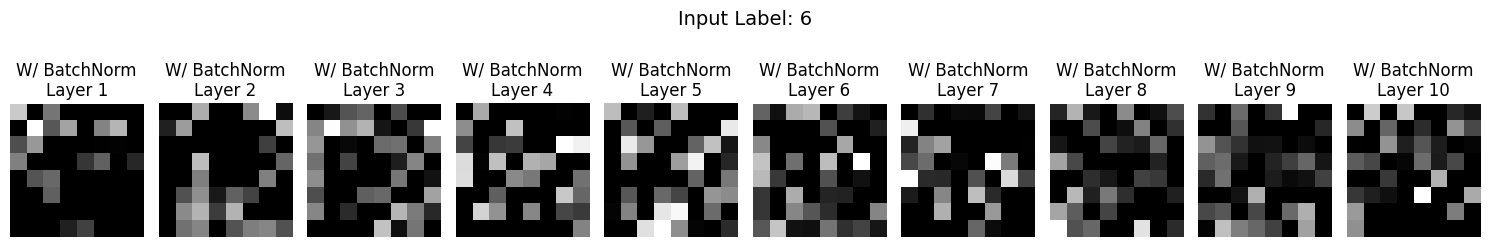

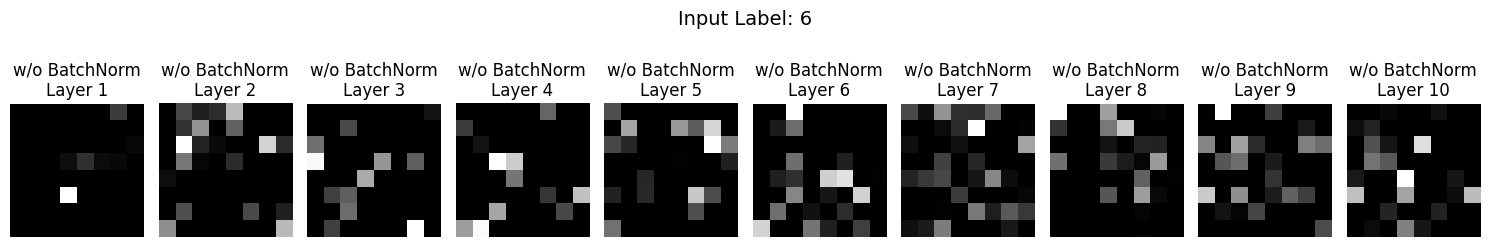

In [ ]:
sample_img, sample_label = next(iter(sample_loader))
print(f"\nSelected Test Image Label: {sample_label.item()}")
visualize_features(model_bn, sample_img[0], sample_label.item(), "W/ BatchNorm")
visualize_features(model_no_bn, sample_img[0], sample_label.item(), "w/o BatchNorm")